## Clusters
Idea is to have different clusters form houses based on similarity.
Firstly we have to figure out what to do with missing data.
We don't want to delete any data because the project will have to involve all houses in Tallinn, especially given that the houses
who have more NaN values to them are probably in worse shape and are on the top of the list for being renovated
Since we want to have all the houses to be represented in a way that NaN values don't clump up with other values we will
replace NaN values with the MEAN value of the column.
By the end I will save the results in a new CSV file

Ideas: remove cols with over 85% data missing bcs there is too little data.
Imputate missing values with: https://scikit-learn.org/stable/modules/impute.html



<AxesSubplot:>

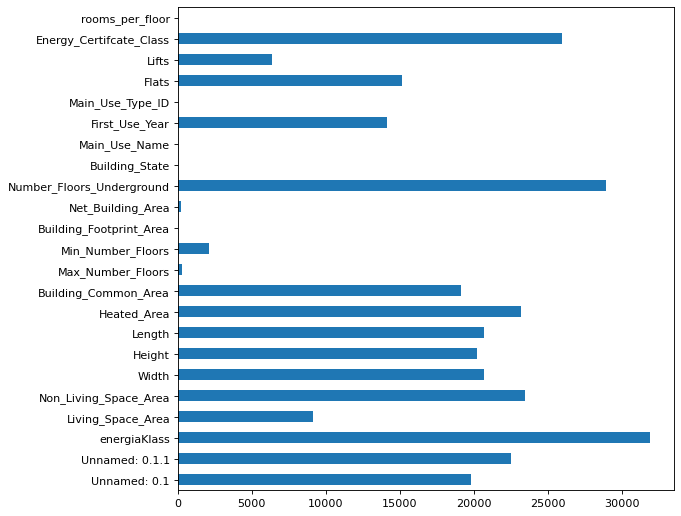

In [18]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

data_frame: pd.DataFrame = pd.read_csv("bigSet32000with_derrivatives.csv")

data_null = data_frame.isna().sum()
plt.figure(figsize=(8,8), dpi=80)
data_null[data_null!=0].plot(kind='barh')



From our last plt we can see that Number_Floors_Underground, energiaKlass/Energy_Certificate_Class
don't have that much data in them, so we will remove them.
For numerical data I will replace the NaN values with mean because that won't manipulate the truthfulness of the data that much
For string data I will use mode to so that some data exists although this will manipulate the results I have to admit and a better solution should be found.

This step should be modified by using random forest as missing value predictor

In [19]:
data_frame.drop(['Number_Floors_Underground', 'energiaKlass',
                 'Energy_Certifcate_Class', 'Unnamed: 0', 'Unnamed: 0.1.1', 'Unnamed: 0.2', 'Unnamed: 0.1']
                ,axis=1, inplace=True)
data_types: dict = data_frame.dtypes
for col_name, col_type in data_types.items():
    if np.issubdtype(object, col_type.type) is False:
        data_frame[col_name].fillna(round(data_frame[col_name].mean(), 1), inplace=True)
    else:
        # data_frame[col_name].fillna(data_frame[col_name].mode(), inplace=True)
        data_frame.drop([col_name], axis=1, inplace=True)
data_frame.to_csv(".\out.csv",index=False)


## Elbow method
Next up we are going to try out a clustering algorithm
First I'm going Bto try out a simple algorith called K-means is pretty simple, but it has a trick
that you have to select how many clusters will there be.
The idea is to firstly calculate the Within Cluster Sum of Squares(WCSS) to get the best cluster number.
https://towardsdatascience.com/machine-learning-algorithms-part-9-k-means-example-in-python-f2ad05ed5203

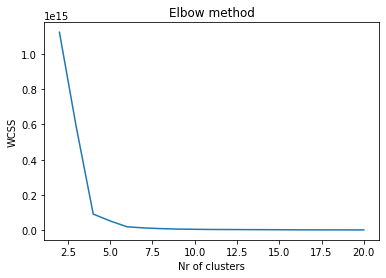

In [20]:
from matplotlib.ticker import MaxNLocator
from sklearn.cluster import KMeans
max_cluster_level: int = 20
wcss = []

cluster_range: list = list(range(2, max_cluster_level + 1))

for cluster in cluster_range:
    kmeans = KMeans(n_clusters=cluster, init='k-means++', max_iter=300, n_init=1, random_state=0)
    kmeans.fit(data_frame)
    wcss.append(kmeans.inertia_)

plt.plot(cluster_range, wcss)
plt.title('Elbow method')
plt.xlabel('Nr of clusters')
plt.ylabel('WCSS')
plt.show()

The best cluster leve turned out to be 4, so we will run it with that.
Guess I will have to explain the other inputs as well

In [21]:
# from sklearn.preprocessing import MinMaxScaler
#
# labels = list(data_frame.columns.values)
# scaler = MinMaxScaler()
# scaler.fit(data_frame)
# data_frame = scaler.transform(data_frame)
# data_frame = pd.DataFrame(data_frame, columns=labels)
# data_frame.to_csv(".\out.csv",index=False)


In [22]:
from sklearn.cluster import KMeans
cluster_level = 4
kmeans = KMeans(n_clusters=cluster_level, init='k-means++', max_iter=300, n_init=10, random_state=0)
y_kmeans = kmeans.fit_predict(data_frame)
data_frame['cluster'] = y_kmeans
data_frame.to_csv(".\out.csv",index=False)


Now do a correlation matrix between the variables and see what variable causes the clustering
Ref: https://medium.com/@sebastiannorena/finding-correlation-between-many-variables-multidimensional-dataset-with-python-5deb3f39ffb3

In [23]:
def make_heatmap(data: pd.DataFrame):
    corr = data.corr()
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
    fig.colorbar(cax)
    ticks = np.arange(0, len(data.columns), 1)
    ax.set_xticks(ticks)
    plt.xticks(rotation=90)
    ax.set_yticks(ticks)
    ax.set_xticklabels(data.columns)
    ax.set_yticklabels(data.columns)
    plt.show()

Let's try two methods, try to heatmap each cluster separately and then heatmap all the data at once, let's see what differes

C:\Users\peete\AppData\Local\Temp\ipykernel_7256\1357091897.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data_frame.drop(['cluster'], axis=1, inplace=True)


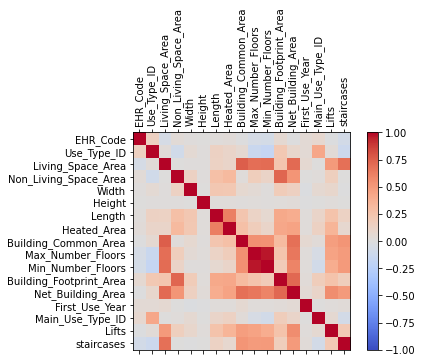

C:\Users\peete\AppData\Local\Temp\ipykernel_7256\1357091897.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data_frame.drop(['cluster'], axis=1, inplace=True)


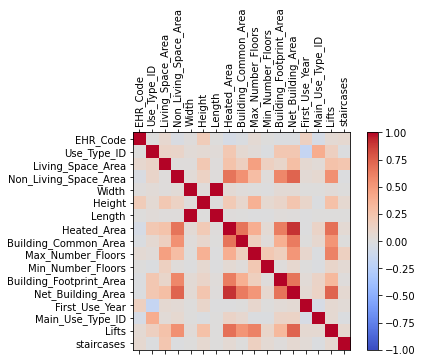

C:\Users\peete\AppData\Local\Temp\ipykernel_7256\1357091897.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data_frame.drop(['cluster'], axis=1, inplace=True)


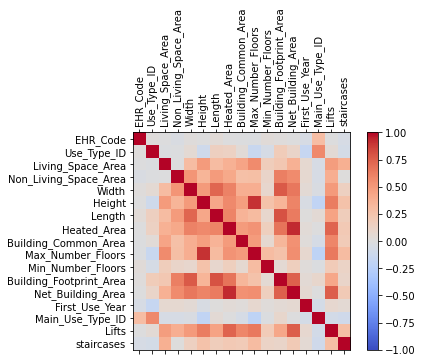

C:\Users\peete\AppData\Local\Temp\ipykernel_7256\1357091897.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data_frame.drop(['cluster'], axis=1, inplace=True)


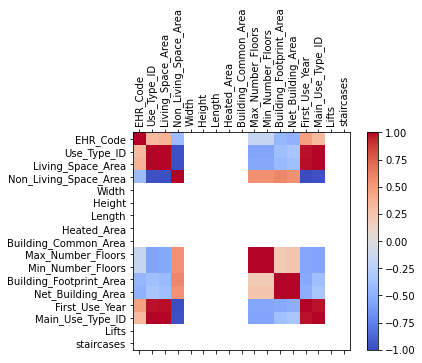

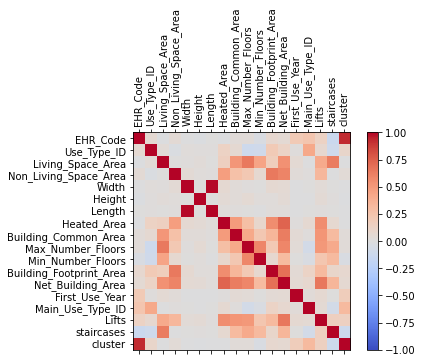

In [24]:
cluster_numbers: set = set(data_frame['cluster'].tolist())
for i in cluster_numbers:
    new_data_frame: pd.DataFrame = data_frame[data_frame.cluster == i]
    new_data_frame.drop(['cluster'], axis=1, inplace=True)
    make_heatmap(new_data_frame)
make_heatmap(data_frame)